# Gaussian Processes

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
import pymc3 as pm
from pymc3 import gp

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
import theano
import theano.tensor as tt

In [4]:
import arviz as az

In [5]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

In [6]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=20)     # fontsize of the axes title
plt.rc('axes',   labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=20)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=20)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Versions

In [7]:
print("Numpy: ", np.__version__)
print("Scipy: ", sp.__version__)
print("Pandas: ", pd.__version__)
print("pymc3: ", pm.__version__)
print("theano: ", theano.__version__)
print("arviz: ", az.__version__)

Numpy:  1.21.5
Scipy:  1.8.0
Pandas:  1.4.1
pymc3:  3.11.4
theano:  1.1.2
arviz:  0.12.0


## Drawing posterior functions from a GP

Create a synthetic dataset:

In [8]:
rng = np.random.default_rng(1354)
x = np.linspace(0.1,10,20)
y = np.sin(x) / x + rng.normal(0, 0.1, len(x))

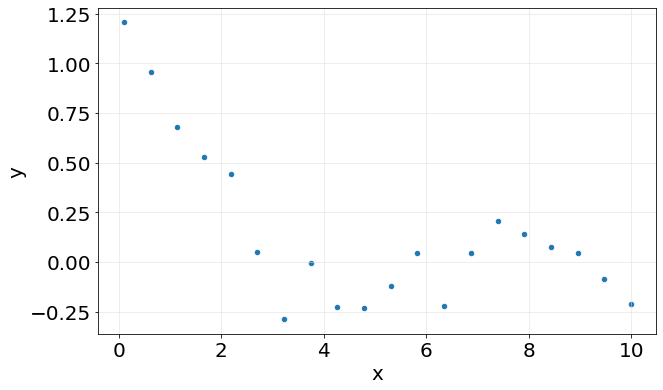

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y,s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

In [33]:
dim = 1                                             # This is a 1-dimensional problem
X = x.reshape((len(x),1))                           # marginal_likelihood expects a column vector, not a row vector

In [34]:
with pm.Model() as myModel:
    lam = pm.Gamma('lambda', 2, 0.5)
    covarianceFunction = gp.cov.ExpQuad(dim, ls=lam)
    myGP = gp.Marginal(cov_func = covarianceFunction)
    sigma = pm.HalfCauchy('sigma', 1)
    likelihood = myGP.marginal_likelihood('y', X=X, y=y, noise=sigma)
    trace = pm.sample(chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


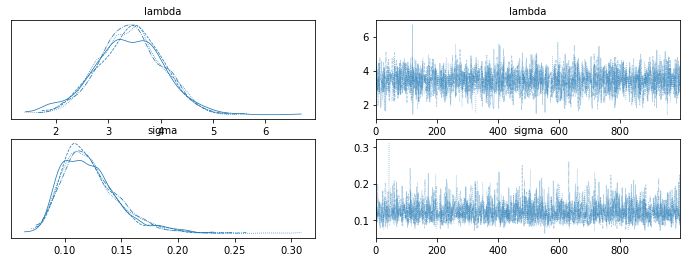

In [35]:
fig = az.plot_trace(trace)

In [36]:
az.summary(trace, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,3.414,0.626,2.186,4.636,0.012,0.009,2714.904,2064.489,1.003
sigma,0.122,0.026,0.083,0.176,0.000,0.000,3021.365,2527.415,1.000


Find the Maximum A Posteriori values for the scale length $\lambda$ of our covariance function:

In [37]:
MAP = pm.find_MAP(model=myModel)
print("MAP scale length: ", MAP['lambda'])


MAP scale length:  3.453992006478823


Compute the mean posterior $E[f(x^*)]$ manually:

In [38]:
Xnew = np.linspace(0.01, 15, 200).reshape((200,1))             # Column vector instead of row vector

In [39]:
N = len(x)
cov = gp.cov.ExpQuad(1, MAP['lambda'])
K = cov(X)
Kstar = cov(X, Xnew)
Knoise = K + MAP['sigma'] * tt.eye(N)

L = np.linalg.cholesky(Knoise.eval())
A = np.linalg.solve(L.T, np.linalg.solve(L, y))
meanPosterior = Kstar.T.eval() @ A

Sample the Gaussian process for a few functions which we will also plot:

In [40]:
with myModel:
    f = myGP.conditional('f', Xnew)
    posteriorPredictive = pm.sample_posterior_predictive(trace, var_names=['f'], samples=100)

/Users/joris/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


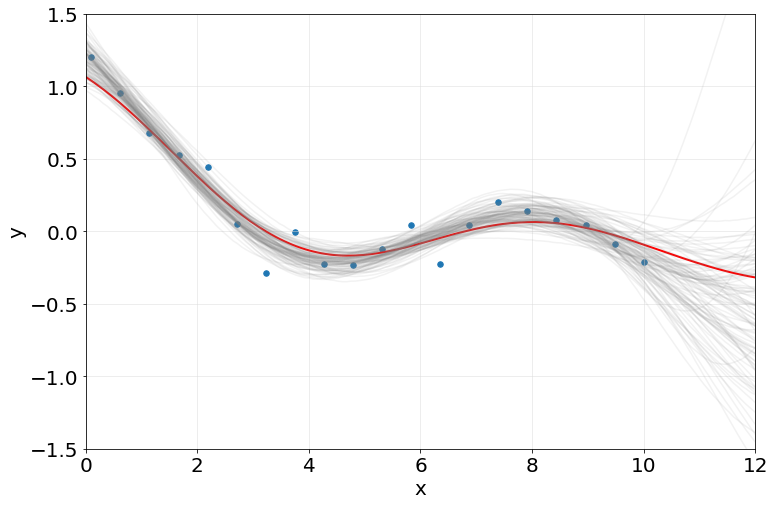

In [41]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.plot(Xnew, meanPosterior, c='red', linewidth=2)
ax.scatter(x,y,s=30,c="C0")
plt.plot(Xnew, posteriorPredictive['f'].T, c='grey', alpha=0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_xlim(0, 12)
ax.set_ylim(-1.5, 1.5)
plt.show()

## Another example

#### Create a dataset

In [58]:
rng = np.random.default_rng(13534)

x = np.linspace(0, 1, 300)
ytrue = np.sin(2*np.pi*x) + np.sin(7*np.pi*x)
y = ytrue + rng.normal(0.0, 0.3, len(x))

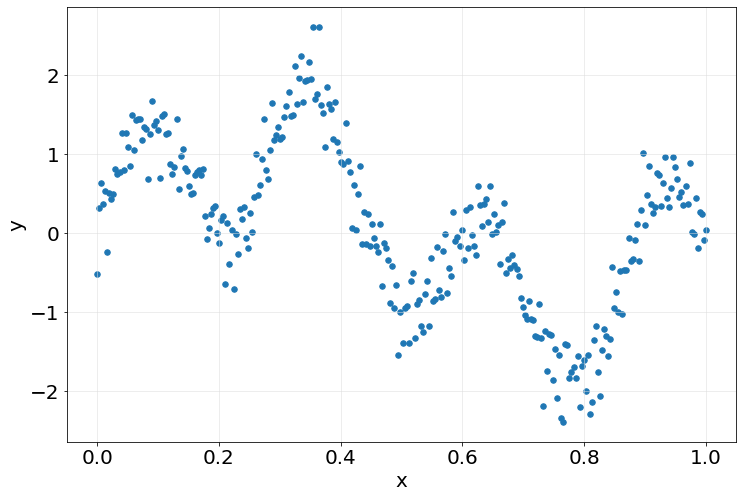

In [101]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(x,y,s=30,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Put the GP fitting into a function 

In [109]:
def fitGP(x,y,lamda):
    
    dim = 1                                      # This is a 1-dimensional problem
    X = x.reshape((len(x),1))                    # marginal_likelihood expects a column vector, not a row vector

    # Fit the GP model
    
    with pm.Model() as myModel:
        sigmaCovFunction = pm.HalfCauchy('sigma_cov', 5)
        covarianceFunction = gp.cov.Constant(sigmaCovFunction) * gp.cov.ExpQuad(dim, ls=lamda)
        myGP = gp.Marginal(cov_func = covarianceFunction)
        sigmaNoise = pm.HalfCauchy('sigma', 1)
        likelihood = myGP.marginal_likelihood('y', X=X, y=y, noise=sigmaNoise)
        trace = pm.sample(chains=3, cores=2, return_inferencedata=True)
   
    # Estimate the posterior predictive distribution
    
    with myModel:
        f = myGP.conditional('f', Xnew)
        posteriorPredictive = pm.sample_posterior_predictive(trace, var_names=['f'], samples=500)
    
    return myModel, trace, Xnew, posteriorPredictive['f']

#### Try $\lambda = 1$

In [110]:
model, trace, Xnew, posteriorPredictive = fitGP(x,y,lamda=1.0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, sigma_cov]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 181 seconds.
/Users/joris/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


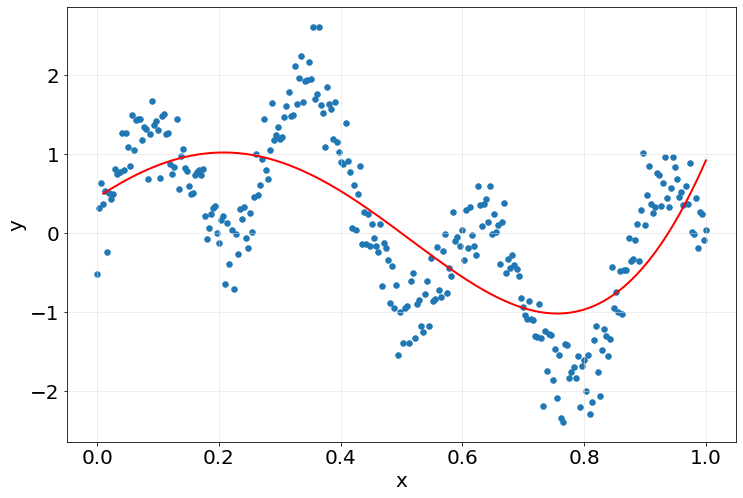

In [111]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

meanPosterior = posteriorPredictive.mean(axis=0)

plt.plot(Xnew, meanPosterior, c='red', linewidth=2)
ax.scatter(x,y,s=30,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Try $\lambda = 0.001$

In [112]:
model, trace, Xnew, posteriorPredictive = fitGP(x,y,lamda=0.001)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, sigma_cov]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 298 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 290 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3425193664249872, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/joris/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


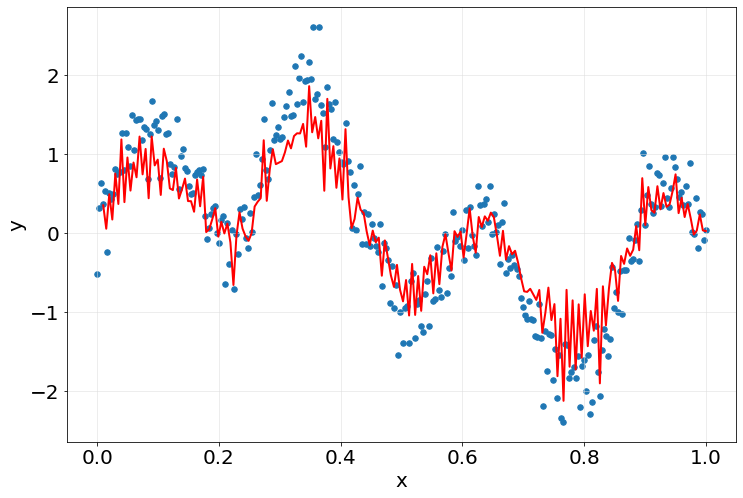

In [113]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

meanPosterior = posteriorPredictive.mean(axis=0)

plt.plot(Xnew, meanPosterior, c='red', linewidth=2)
ax.scatter(x,y,s=30,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Include $\lambda$ in the probabilistic model 

In [114]:
dim = 1                        # This is a 1-dimensional problem
X = x.reshape((len(x),1))      # marginal_likelihood expects a column vector, not a row vector
    
with pm.Model() as myModel:
     lamda = pm.Gamma('lambda', 2, 0.5)
     sigmaCovFunction = pm.HalfCauchy('sigma_cov', 5)
     covarianceFunction = gp.cov.Constant(sigmaCovFunction) * gp.cov.ExpQuad(dim, ls=lamda)
     myGP = gp.Marginal(cov_func = covarianceFunction)
     sigmaNoise = pm.HalfCauchy('sigma', 1)
     likelihood = myGP.marginal_likelihood('y', X=X, y=y, noise=sigmaNoise)

     trace = pm.sample(chains=3, cores=2, return_inferencedata=True)
       
     f = myGP.conditional('f', Xnew)
     posteriorPredictive = pm.sample_posterior_predictive(trace, var_names=['f'], samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, sigma_cov, lambda]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 347 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/Users/joris/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


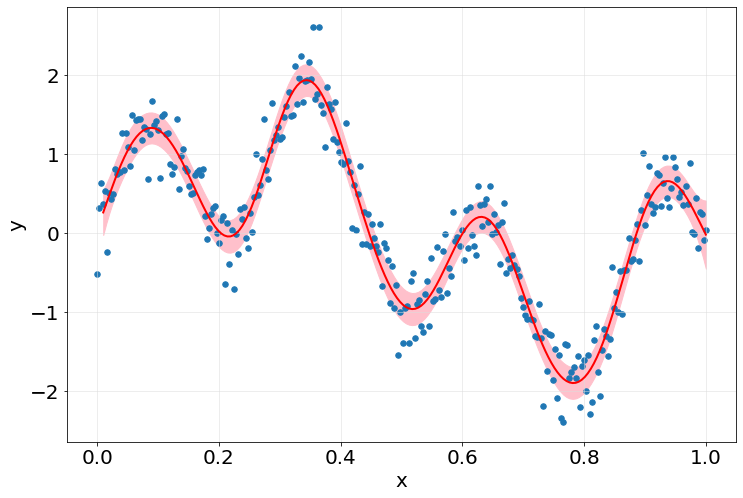

In [119]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

mean = posteriorPredictive['f'].mean(axis=0)
std = posteriorPredictive['f'].std(axis=0, ddof=1)

ax.plot(Xnew, mean, c='red', linewidth=2)
ax.fill_between(Xnew.flatten(), mean-3*std, mean+3*std, color="pink", alpha=1)

ax.scatter(x,y,s=30,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

## Another example: the Mauna Loa dataset

This example is strongly inspired by an example in the PyMC3 documentation pages.

In [120]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/CO2_MaunaLoa_monthly.csv"
data = pd.read_csv(url)
data.head()
t = data['year'].values
y = data['co2'].values

The following dataset shows why our planet risks to become uninhabitable if we do not act (very) fast:

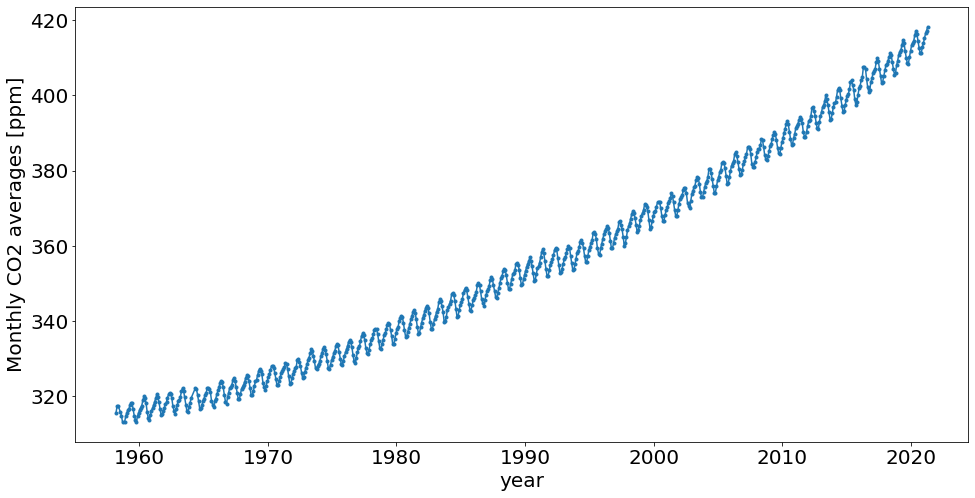

In [121]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(data.year, data.co2, marker='o', markersize=3)
ax.set_xlabel("year")
ax.set_ylabel("Monthly CO2 averages [ppm]")
plt.show()

The following model uses a sum of three GPs to capture the periodic trend, the long-term trend, and small/medium term irregularities. Cf the [PyMC3 documentation page](https://docs.pymc.io/api/gp/cov.html) on available covariance functions for a Gaussian Process.

In [122]:
with pm.Model() as model:
    
    # The slowly varying long-term trend
    
    etaTrend      = pm.HalfCauchy("etaTrend", beta=2, testval=2.0)
    lambdaExpQuad = pm.Gamma("lambdaExpQuad", alpha=4, beta=0.1)
    covTrend      = etaTrend**2 * gp.cov.ExpQuad(1, lambdaExpQuad)
    
    myGPtrend = pm.gp.Marginal(cov_func=covTrend)

    # Periodic component: PyMC3 has only one covariance function available to model periodic data
    # The periodicity may not remain exact, so we multiply by a Matern52 function to take into account
    # a decay of the exact periodic component. We put a long decay time, however, because we don't expect
    # this to happen any soon.
    
    period         = pm.Normal("period",          mu=1, sigma=0.05)
    lambdaPeriodic = pm.Gamma("lambdaPeriodic",   alpha=4, beta=3)
    etaPeriodic    = pm.HalfCauchy("etaPeriodic", beta=2, testval=1.0)
    lambdaMatern52 = pm.Gamma("lambdaMatern52",   alpha=10, beta=0.075)
    covSeasonal    = etaPeriodic**2 * gp.cov.Periodic(1, period, lambdaPeriodic) * gp.cov.Matern52(1, lambdaMatern52)
    
    myGPseasonal = pm.gp.Marginal(cov_func=covSeasonal)
    
    # On top of all these perodicities and trends, there is also noise. It's unclear whether it's pure
    # white noise, so we also add a Matern32 process to add noise on a somewhat longer time scale.
    
    etaNoise       = pm.HalfNormal("etaNoise", sigma=0.5, testval=0.05)
    lambdaMatern32 = pm.Gamma("lambdaNoise", alpha=2, beta=4)
    sigma          = pm.HalfNormal("sigma", sigma=0.25, testval=0.05)
    covNoise       = etaNoise**2 * gp.cov.Matern32(1, lambdaMatern32) + gp.cov.WhiteNoise(sigma)

    # The Gaussian process is a sum of these three components
    
    myGP = myGPseasonal + myGPtrend

    # The likelihood
    
    likelihood = myGP.marginal_likelihood("y", X=t.reshape((len(t),1)), y=y, noise=covNoise)

    # Find the MAP values 
    
    MAP = pm.find_MAP(include_transformed=True)

Use the GP to predict the posterior mean and the posterior variance between the years 2015 and 2030.

In [123]:
tnew = np.linspace(2015, 2030, 15*12*2)[:,None]
mu, var = myGP.predict(tnew, point=MAP, diag=True)
sigma = np.sqrt(var)

Plot the mean, and the 1-sigma and 3-sigma intervals.

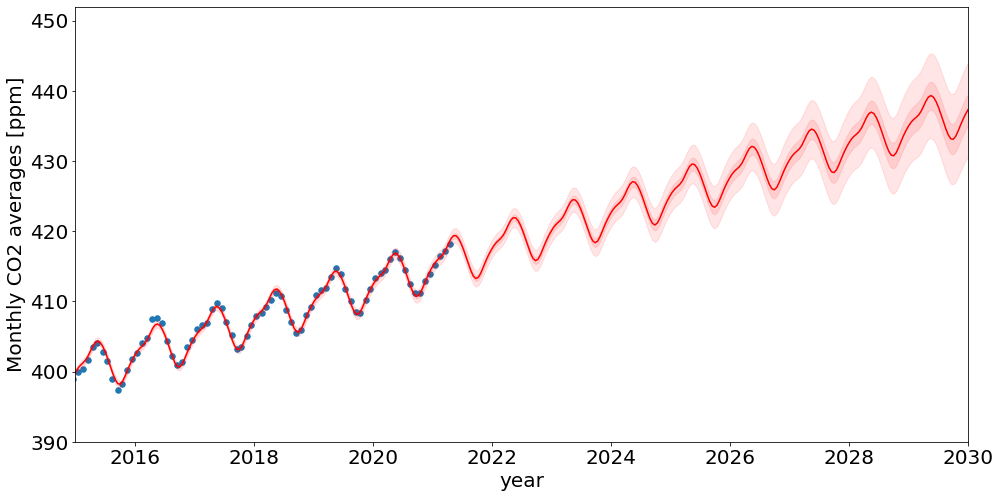

In [124]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.scatter(data.year, data.co2, s=30)
ax.plot(tnew, mu, c="red")
ax.fill_between(tnew.ravel(), mu-sigma, mu+sigma, color="red", alpha=0.1)
ax.fill_between(tnew.ravel(), mu-3*sigma, mu+3*sigma, color="red", alpha=0.1)
ax.set_xlabel("year")
ax.set_ylabel("Monthly CO2 averages [ppm]")
ax.set_xlim(2015, 2030)
ax.set_ylim(390,)
plt.show()